In [254]:
from matplotlib import pyplot as plt
import numpy as np
import numba
from dask import array as da

from dataclasses import dataclass
from typing import Callable

In [255]:
%matplotlib widget

In [256]:
@dataclass
class BoundingBox:
    width: int
    height: int
    center: complex
    extent: complex
    
    def scale(self) -> float:
        """Computes the correct scale to display the selected region.
        
        Returns:
            floating point value that scales pixels to desired complex domain.
        """
        return max(self.extent.real / self.width,
                   self.extent.imag / self.height)
    
    def grid(self):
        """Return the complex values on the grid in a 2d array."""
        x0 = self.center - self.extent / 2
        x1 = self.center + self.extent / 2
        g = np.mgrid[x0.imag:x1.imag:self.height*1j,
                     x0.real:x1.real:self.width*1j]
        return g[1] + g[0]*1j
    
    def split(self, n):
        """Split the domain in nxn subdomains, and return a grid of BoundingBoxes."""
        sd = self.extent / n
        x0 = self.center - self.extent / 2 + sd / 2
        return [[BoundingBox(width=self.width//n, height=self.height//n,
                             center=x0 + i * sd.real + j * sd.imag * 1j,
                             extent=sd) for i in range(n)]
                for j in range(n)]

    def zeros(self, dtype=int):
        """Create a 2D array with the specified shape of (width, height)."""
        return np.zeros(dtype=dtype, shape=(self.width, self.height))
    
    def np_map(self, f, *args):
        return f(self.grid(), *args)
    
    def da_map(self, f, *args):
        g = da.from_array(self.grid(), chunks=(256,256))
        return f(g, *args)
    
    def int_map(self, f, *args):
        """Map a function over the given complex domain."""
        return bb_int_map(f, self.width, self.height, self.center, self.scale(), *args)
    
    def plot(self, value, name="z", ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        else:
            fig = None
        plot_extent = (self.width + 1j * self.height) * self.scale()
        z1 = self.center - plot_extent / 2
        z2 = z1 + plot_extent
        ax.imshow(value, origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
        ax.set_xlabel(f"$\Re({name})$")
        ax.set_ylabel(f"$\Im({name})$")
        return fig, ax

In [257]:
@numba.jit(nopython=True, nogil=True)
def bb_int_map(f: Callable[(complex,), int], width: int, height: int, center: complex, scale: complex, *args):
    result = np.zeros((height, width), np.int64)
    for j in range(height):
        for i in range(width):
            z = center + (i - width // 2 + (j - height // 2) * 1j) * scale
            result[j, i] = f(z, *args)
    return result

In [258]:
@numba.jit(nopython=True, nogil=True)
def iteration_count(f: Callable[(complex,), complex], stop: Callable[(complex,), bool], start: complex, max_iter: int, *args) -> int:
    x = start
    for k in range(max_iter):
        x = f(x, *args)
        if stop(x):
            break
    return k

In [259]:
@numba.jit(nopython=True, nogil=True)
def radius_2_condition(z: complex) -> bool:
    return (z*z.conjugate()).real >= 4.0

In [260]:
def mandelbrot_ic(max_iter: int) -> Callable[(complex,), int]:
    @numba.jit(nopython=True, nogil=True)
    def f(c: complex):
        return iteration_count(lambda z, c: z**2 + c, radius_2_condition, 0.0, max_iter, c)
    return f

In [261]:
def julia_ic(max_iter: int) -> Callable[(complex, complex), int]:
    @numba.jit(nopython=True, nogil=True)
    def f(z0: complex, c: complex):
        return iteration_count(lambda z, c: z**2 + c, radius_2_condition, z0, max_iter, c)
    return f    

In [262]:
bb = BoundingBox(512, 512, -0.8+0.0j, 3.0+2.0j)
c = -1.1195+0.2718j
bb2 = BoundingBox(
    width = 1024,
    height = 1024,
    center = c,
    extent = 0.005+0.005j)

In [272]:
mb = mandelbrot_ic(1024)
julia = julia_ic(1024)

Run once to compile:

In [273]:
baseline = bb2.int_map(mb);

Time:

In [265]:
%%timeit -n 15 -r 1
bb2.int_map(mb)

244 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 15 loops each)


In [266]:
def mandelbrot_ic_vec(max_iter: int) -> Callable[(complex,), int]:
    @numba.vectorize()
    def f(c: complex):
        return iteration_count(lambda z, c: z**2 + c, radius_2_condition, 0.0, max_iter, c)
    return f

In [267]:
mb_vec = mandelbrot_ic_vec(1024)

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:xlabel='$\\Re(z)$', ylabel='$\\Im(z)$'>)

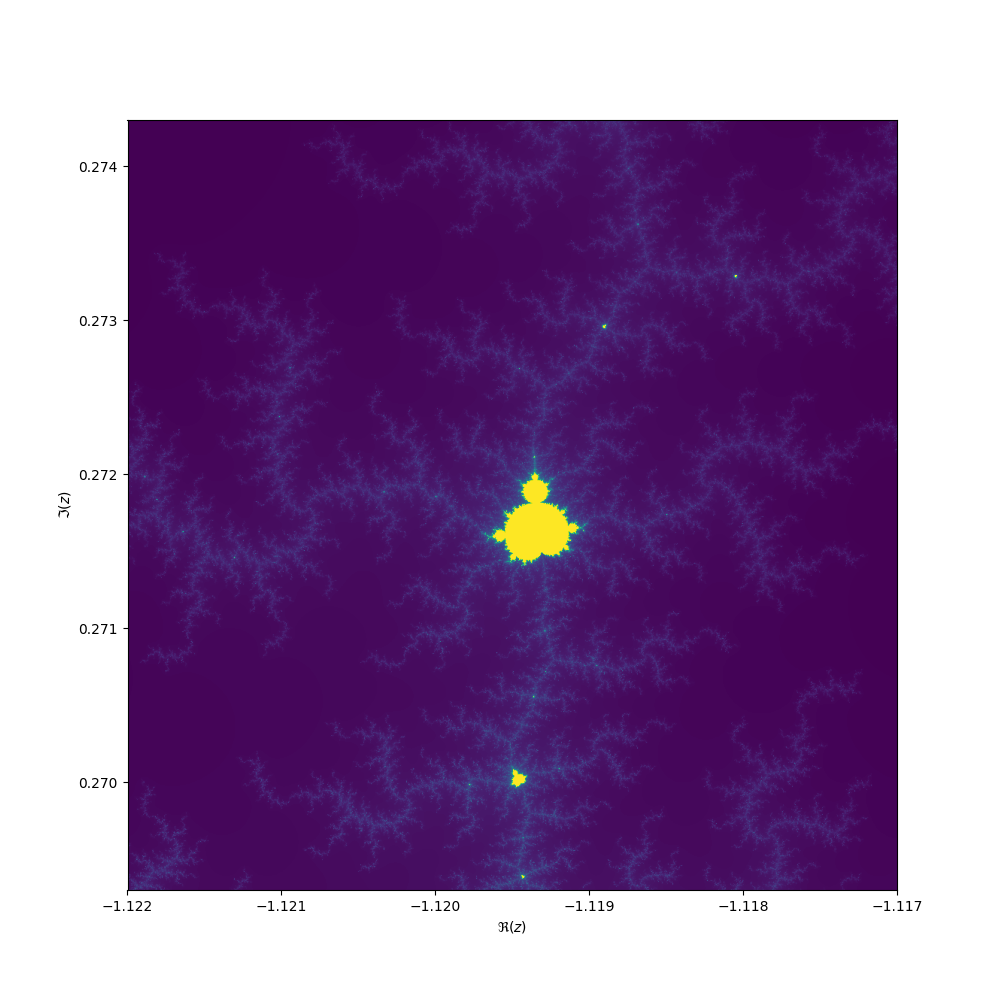

In [268]:
bb2.plot(bb2.np_map(mb_vec))

In [269]:
%%timeit -n 15 -r 1
bb2.np_map(mb_vec)

251 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 15 loops each)


In [270]:
%%timeit -n 15 -r 1
wf = bb.da_map(mb_vec)
wf.compute(num_workers=8)

92.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 15 loops each)


In [244]:
bb2.split(4)

[[BoundingBox(width=256, height=256, center=(-1.1213749999999998+0.26992499999999997j), extent=(0.00125+0.00125j)),
  BoundingBox(width=256, height=256, center=(-1.1201249999999998+0.26992499999999997j), extent=(0.00125+0.00125j)),
  BoundingBox(width=256, height=256, center=(-1.1188749999999998+0.26992499999999997j), extent=(0.00125+0.00125j)),
  BoundingBox(width=256, height=256, center=(-1.1176249999999999+0.26992499999999997j), extent=(0.00125+0.00125j))],
 [BoundingBox(width=256, height=256, center=(-1.1213749999999998+0.27117499999999994j), extent=(0.00125+0.00125j)),
  BoundingBox(width=256, height=256, center=(-1.1201249999999998+0.27117499999999994j), extent=(0.00125+0.00125j)),
  BoundingBox(width=256, height=256, center=(-1.1188749999999998+0.27117499999999994j), extent=(0.00125+0.00125j)),
  BoundingBox(width=256, height=256, center=(-1.1176249999999999+0.27117499999999994j), extent=(0.00125+0.00125j))],
 [BoundingBox(width=256, height=256, center=(-1.1213749999999998+0.272

In [245]:
from dask import delayed

In [246]:
@delayed
def gather(*args):
    return list(args)

In [274]:
wf = gather(*[gather(*[delayed(box.int_map)(mb) for box in row]) for row in bb2.split(4)])

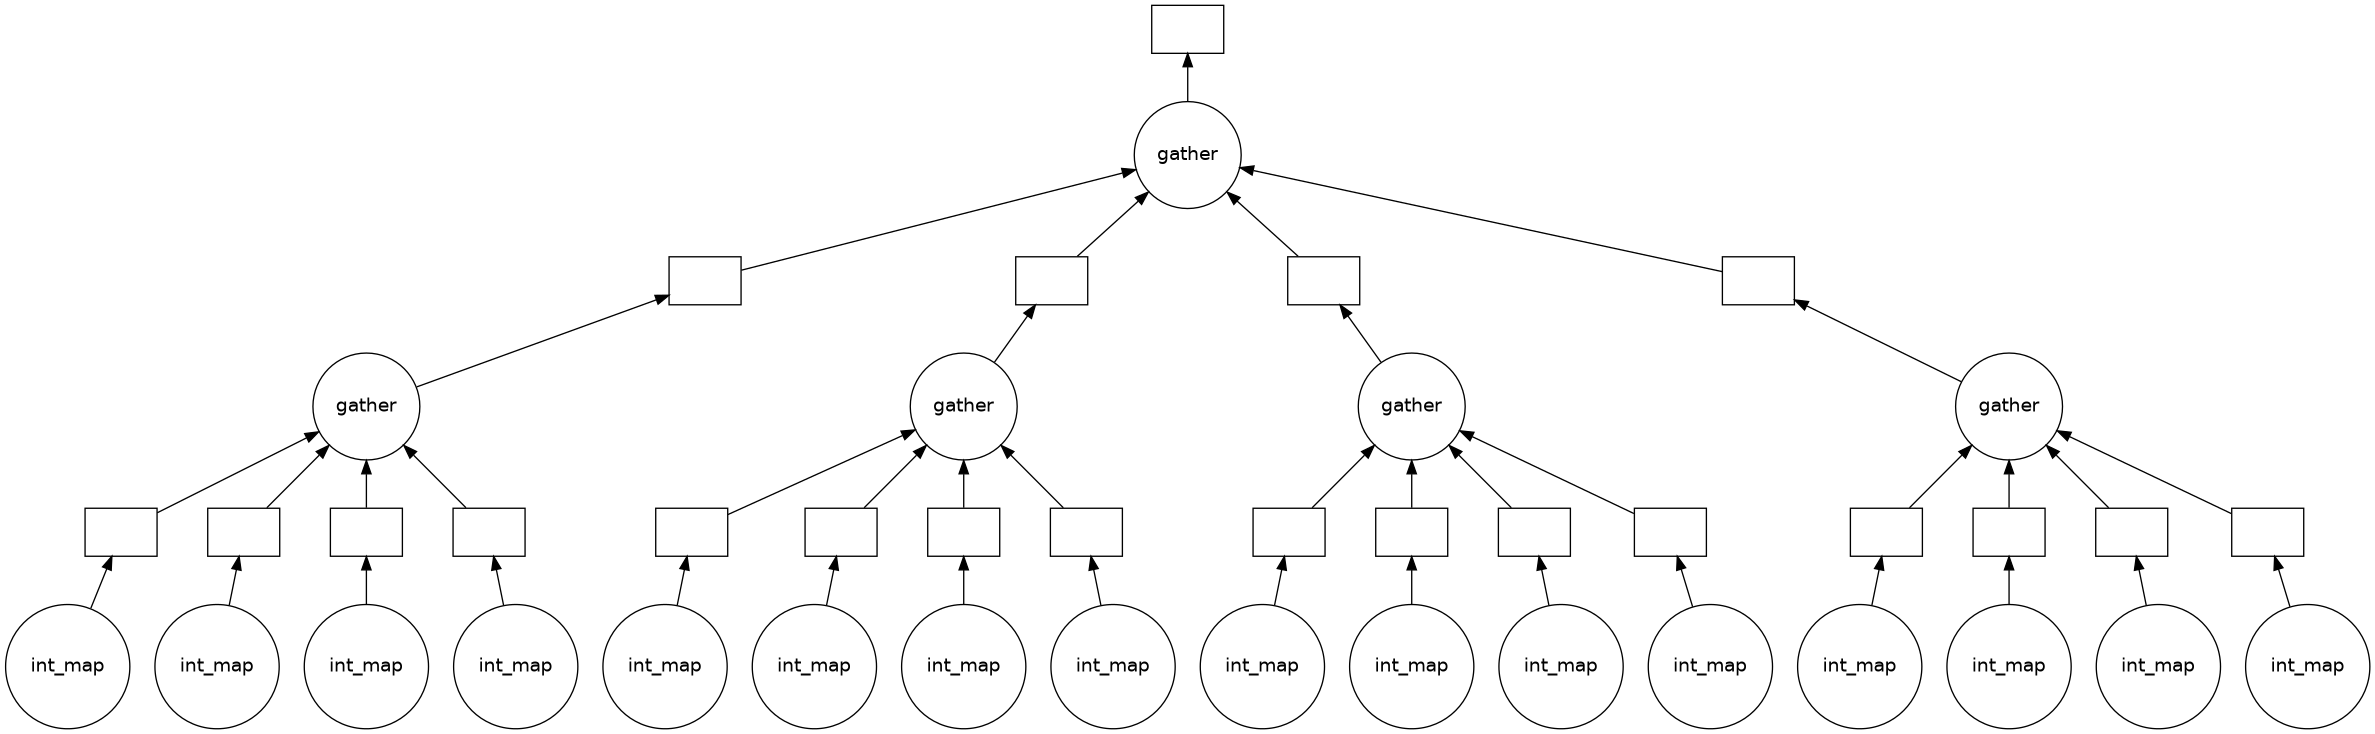

In [248]:
wf.visualize()

In [252]:
%%timeit -n 15 -r 1
wf = gather(*[gather(*[delayed(box.int_map)(mb) for box in row]) for row in bb2.split(4)])
np.block(wf.compute(num_workers=16))

39.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 15 loops each)


In [220]:
help(wf.compute)

Help on method compute in module dask.base:

compute(**kwargs) method of dask.delayed.Delayed instance
    Compute this dask collection
    
    This turns a lazy Dask collection into its in-memory equivalent.
    For example a Dask array turns into a NumPy array and a Dask dataframe
    turns into a Pandas dataframe.  The entire dataset must fit into memory
    before calling this operation.
    
    Parameters
    ----------
    scheduler : string, optional
        Which scheduler to use like "threads", "synchronous" or "processes".
        If not provided, the default is to check the global settings first,
        and then fall back to the collection defaults.
    optimize_graph : bool, optional
        If True [default], the graph is optimized before computation.
        Otherwise the graph is run as is. This can be useful for debugging.
    kwargs
        Extra keywords to forward to the scheduler function.
    
    See Also
    --------
    dask.base.compute

